Optimisation d'un modèle uniform mix à 3 modes pour noise2

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D
import torch.nn.functional as F

# Make local modules importable
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

import functions  # noqa: E402

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

N = 2**16
M = 1
n_bins = 300
bin_centers = torch.linspace(-6.0, 6.0, n_bins, device=device)
dx = bin_centers[1] - bin_centers[0]

SAVE_DIR = r"C:\Users\gauti\OneDrive\Documents\UE D recherche\UE_D_Recherche\code"
FILENAME = "best_trimodal_params.pt"
SAVE_PATH = os.path.join(SAVE_DIR, FILENAME)
os.makedirs(SAVE_DIR, exist_ok=True)

# Targets
try:
    data = np.load("Train_TurbModane_N65536_sampling4_Nreal256_v3.npz")
    S2_target = torch.from_numpy(data["S2"].mean(axis=0)).float().to(device)
    flatness_target = torch.from_numpy(data["Flat"].mean(axis=0)).float().to(device)
    scales = torch.from_numpy(data["scales"]).float().to(device)
except FileNotFoundError:
    print("Targets not found; using synthetic fallback.")
    scales = torch.logspace(1, 4, 10, device=device)
    S2_target = scales ** (-0.1)
    flatness_target = torch.ones_like(scales) * 3.0


class TrimodalUniformGenerator(torch.nn.Module):
    """Three-box density with shared steepness."""

    def __init__(self):
        super().__init__()
        self.alpha_logit = torch.nn.Parameter(torch.log(torch.tensor(0.27 / (1 - 0.27))))
        self.log_width_center = torch.nn.Parameter(torch.log(torch.tensor(2.04)))
        self.log_mu_side = torch.nn.Parameter(torch.log(torch.tensor(1.07)))
        self.log_width_side = torch.nn.Parameter(torch.log(torch.tensor(0.66)))
        self.steepness = 50.0

    def forward(self, x):
        alpha = torch.sigmoid(self.alpha_logit)
        w_c = torch.exp(self.log_width_center)
        mu_s = torch.exp(self.log_mu_side)
        w_s = torch.exp(self.log_width_side)

        box_center = torch.sigmoid(self.steepness * (x + w_c / 2)) * torch.sigmoid(self.steepness * (w_c / 2 - x))
        dens_center = box_center / (w_c + 1e-6)

        box_left = torch.sigmoid(self.steepness * (x + mu_s + w_s / 2)) * torch.sigmoid(self.steepness * (-mu_s + w_s / 2 - x))
        dens_left = box_left / (w_s + 1e-6)

        box_right = torch.sigmoid(self.steepness * (x - mu_s + w_s / 2)) * torch.sigmoid(self.steepness * (mu_s + w_s / 2 - x))
        dens_right = box_right / (w_s + 1e-6)

        total_density = alpha * dens_center + ((1 - alpha) / 2) * (dens_left + dens_right)
        return torch.log(total_density + 1e-9)


In [4]:
model = TrimodalUniformGenerator().to(device)
c1 = torch.tensor(0.36, device=device, requires_grad=True)
c2 = torch.tensor(0.02, device=device, requires_grad=True)
best_loss = float("inf")

if os.path.exists(SAVE_PATH):
    checkpoint = torch.load(SAVE_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    c1.data.copy_(checkpoint["c1"].to(device))
    c2.data.copy_(checkpoint["c2"].to(device))
    best_loss = checkpoint.get("loss", best_loss)
    print(f"Reloaded checkpoint (loss={best_loss:.5f}).")
else:
    print("No checkpoint found; starting fresh.")

h_mu = torch.tensor(0.0, device=device)
h_sigma = torch.tensor(1.0, device=device)
base_noise = torch.randn(M, N, device=device)
fixed_uniform = torch.rand(M, N, n_bins, device=device)
fixed_gumbel = -torch.log(-torch.log(fixed_uniform + 1e-9) + 1e-9)

alpha_loss, beta_loss, gamma_loss = 0.3, 1.0, 0.3
optimizer = torch.optim.Adam(
    [
        {"params": [model.alpha_logit, model.log_width_center, model.log_mu_side, model.log_width_side], "lr": 1e-3},
        #{"params": [c1, c2], "lr": 1e-3},
    ]
)

Nb_epochs = 41
eps = 1e-8

print("Starting optimization...")
for epoch in range(Nb_epochs):
    optimizer.zero_grad()

    logits = model(bin_centers)
    logits_exp = logits.view(1, 1, -1).expand(M, N, n_bins)
    y_soft = F.softmax((logits_exp + fixed_gumbel) / 2.0, dim=-1)
    noise2 = torch.sum(y_soft * bin_centers, dim=-1)
    noise2 = (noise2 - noise2.mean()) / (noise2.std() + eps)

    noise1 = base_noise * h_sigma + h_mu
    MRW = functions.synthMRWregul_Torch(noise1, noise2, N, c1, c2, np.exp(8), 1.0, 1)

    moments = functions.analyseIncrsTorchcuda(MRW.view(-1, N), scales, device.type)
    S2_sim = torch.exp(moments[:, 0, :]).mean(dim=0)
    flat_sim = moments[:, 2, :].mean(dim=0)

    loss_S2 = alpha_loss * F.mse_loss(S2_sim, S2_target) + (1 - alpha_loss) * F.mse_loss(torch.log(S2_sim + eps), torch.log(S2_target + eps))
    loss_Flat = beta_loss * F.mse_loss(flat_sim, flatness_target) + (1 - beta_loss) * F.mse_loss(torch.log(flat_sim + eps), torch.log(flatness_target + eps))
    loss = gamma_loss * loss_S2 + (1 - gamma_loss) * loss_Flat * 1_000.0

    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            "model_state_dict": model.state_dict(),
            "c1": c1.detach().clone(),
            "c2": c2.detach().clone(),
            "loss": best_loss,
        }, SAVE_PATH)

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:02d} | loss={loss.item():.5f} | "
            f"alpha={torch.sigmoid(model.alpha_logit).item():.4f} "
            f"w_c={torch.exp(model.log_width_center).item():.3f} "
            f"mu_s={torch.exp(model.log_mu_side).item():.3f} "
            f"w_s={torch.exp(model.log_width_side).item():.3f} "
            f"c1={c1.item():.3f} c2={c2.item():.3f}"
        )

print("Optimization done.")


Reloaded checkpoint (loss=2.01099).
Starting optimization...
Epoch 00 | loss=2.01101 | alpha=0.2685 w_c=2.040 mu_s=1.068 w_s=0.659 c1=0.360 c2=0.020
Epoch 00 | loss=2.01101 | alpha=0.2685 w_c=2.040 mu_s=1.068 w_s=0.659 c1=0.360 c2=0.020
Epoch 05 | loss=2.01196 | alpha=0.2688 w_c=2.043 mu_s=1.069 w_s=0.660 c1=0.360 c2=0.020
Epoch 05 | loss=2.01196 | alpha=0.2688 w_c=2.043 mu_s=1.069 w_s=0.660 c1=0.360 c2=0.020
Epoch 10 | loss=2.01156 | alpha=0.2686 w_c=2.042 mu_s=1.068 w_s=0.660 c1=0.360 c2=0.020
Epoch 10 | loss=2.01156 | alpha=0.2686 w_c=2.042 mu_s=1.068 w_s=0.660 c1=0.360 c2=0.020
Epoch 15 | loss=2.01137 | alpha=0.2687 w_c=2.043 mu_s=1.069 w_s=0.660 c1=0.360 c2=0.020
Epoch 15 | loss=2.01137 | alpha=0.2687 w_c=2.043 mu_s=1.069 w_s=0.660 c1=0.360 c2=0.020
Epoch 20 | loss=2.01118 | alpha=0.2686 w_c=2.041 mu_s=1.068 w_s=0.660 c1=0.360 c2=0.020
Epoch 20 | loss=2.01118 | alpha=0.2686 w_c=2.041 mu_s=1.068 w_s=0.660 c1=0.360 c2=0.020
Epoch 25 | loss=2.01107 | alpha=0.2687 w_c=2.042 mu_s=1.069

Best checkpoint loss=2.01099


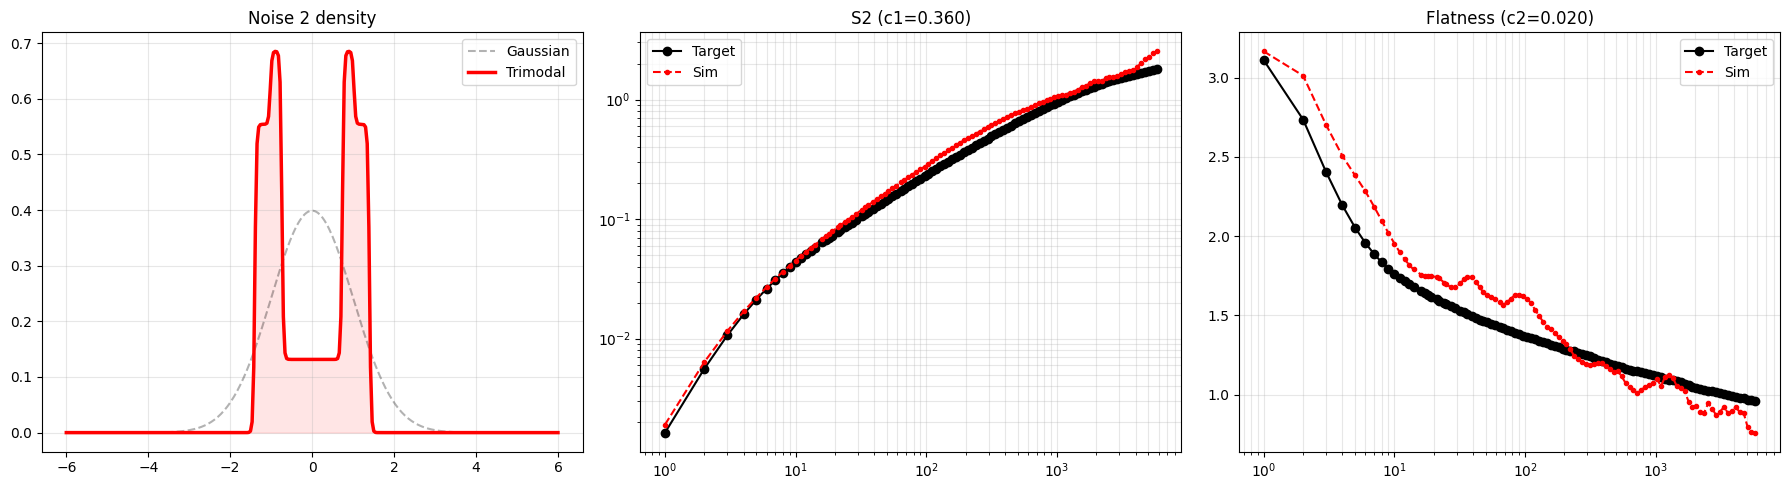

In [5]:
checkpoint = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
c1_final = checkpoint["c1"].to(device)
c2_final = checkpoint["c2"].to(device)
print(f"Best checkpoint loss={checkpoint['loss']:.5f}")

with torch.no_grad():
    logits_final = model(bin_centers)
    probs_final = F.softmax(logits_final, dim=0)
    density_final = probs_final / dx

    logits_expanded = logits_final.view(1, 1, -1).expand(M, N, n_bins)
    random_gumbel = -torch.log(-torch.log(torch.rand_like(logits_expanded) + 1e-9) + 1e-9)
    y_soft = F.softmax((logits_expanded + random_gumbel) / 2.0, dim=-1)

    noise2_val = torch.sum(y_soft * bin_centers, dim=-1)
    noise2_val = (noise2_val - noise2_val.mean()) / (noise2_val.std() + 1e-8)

    noise1 = torch.randn(M, N, device=device)
    MRW_val = functions.synthMRWregul_Torch(noise1, noise2_val, N, c1_final, c2_final, np.exp(8), 1.0, 1)

    moments_val = functions.analyseIncrsTorchcuda(MRW_val.view(-1, N), scales, device.type)
    S2_final = torch.exp(moments_val[:, 0, :]).mean(dim=0)
    flat_final = moments_val[:, 2, :].mean(dim=0)

plt.style.use("default")
fig = plt.figure(figsize=(18, 5))

# Distribution
ax1 = plt.subplot(1, 3, 1)
x = bin_centers.cpu().numpy()
ref_density = torch.exp(D.Normal(0, 1).log_prob(bin_centers)).cpu().numpy()
ax1.plot(x, ref_density, "k--", label="Gaussian", alpha=0.3)
ax1.plot(x, density_final.cpu().numpy(), "r-", label="Trimodal", linewidth=2.5)
ax1.fill_between(x, density_final.cpu().numpy(), color="red", alpha=0.1)
ax1.set_title("Noise 2 density")
ax1.legend()
ax1.grid(True, alpha=0.3)

# S2
ax2 = plt.subplot(1, 3, 2)
sc = scales.cpu().numpy()
ax2.loglog(sc, S2_target.cpu().numpy(), "ko-", label="Target")
ax2.loglog(sc, S2_final.cpu().numpy(), "r.--", label="Sim")
ax2.set_title(f"S2 (c1={c1_final.item():.3f})")
ax2.legend()
ax2.grid(True, which="both", alpha=0.3)

# Flatness
ax3 = plt.subplot(1, 3, 3)
ax3.semilogx(sc, flatness_target.cpu().numpy(), "ko-", label="Target")
ax3.semilogx(sc, flat_final.cpu().numpy(), "r.--", label="Sim")
ax3.set_title(f"Flatness (c2={c2_final.item():.3f})")
ax3.legend()
ax3.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()
